In [7]:
from tensorflow import keras
import tensorflow as tf

from config import config_title as config
from text_utils import Vectorization
from data_utils import load_captions_data, train_val_split, make_dataset, read_image
from models import get_cnn_model, TransformerEncoderBlock, TransformerDecoderBlock, ImageCaptioningModel

""" Preparing the dataset"""
captions_mapping, text_data = load_captions_data(config['train_annotations_file'], split_char=config['split_char'])
train_data, valid_data = train_val_split(captions_mapping)
valid_images = list(valid_data.keys())

print("Number of training samples: ", len(train_data))
print("Number of validation samples: ", len(valid_data))

""" Vectorization """
vectorization = Vectorization(config)
vocab, vocab_size = vectorization.get_vocabulary(text_data)
index_lookup = vectorization.index_lookup(vocab)

train_dataset = make_dataset(list(train_data.keys()), list(train_data.values()), vectorization=vectorization)
valid_dataset = make_dataset(list(valid_data.keys()), list(valid_data.values()), vectorization=vectorization)

""" Build Models """
cnn_model = get_cnn_model()
encoder = TransformerEncoderBlock(embed_dim=config['embed_dim'], dense_dim=config['ff_dim'],
                                  num_heads=config['num_attention_heads'])
decoder = TransformerDecoderBlock(embed_dim=config['embed_dim'], ff_dim=config['ff_dim'],
                                  num_heads=config['num_attention_heads'], seq_len=config['seq_length'],
                                  vocab_size=vocab_size)
caption_model = ImageCaptioningModel(cnn_model=cnn_model, encoder=encoder, decoder=decoder)

""" Training """
# loss function
cross_entropy = keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction="none")
# callbacks
early_stopping = keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True)
# checkpoint_callback = keras.callbacks.ModelCheckpoint(filepath="./checkpoints/callbacks", monitor="val_loss", verbose=0)
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=config['tensorboard_logs_dir'], histogram_freq=1)
# compile model
caption_model.compile(optimizer=keras.optimizers.Adam(), loss=cross_entropy)
# start training loop
history = caption_model.fit(train_dataset, epochs=1,
                            validation_data=valid_dataset,
                            callbacks=[early_stopping, tensorboard_callback])


Number of training samples:  8100
Number of validation samples:  900
254/254 [==============================] - 101s 175ms/step - loss: 4.7284 - acc: 0.2875 - val_loss: 4.1971 - val_acc: 0.3722


In [9]:
caption_model.save_weights('weights/title/4_heads')

Number of training samples:  8100
Number of validation samples:  900


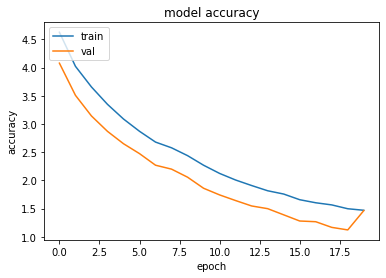

In [7]:
import keras
from matplotlib import pyplot as plt
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [8]:
plt.savefig('foo.png', bbox_inches='tight')

<Figure size 432x288 with 0 Axes>

In [ ]:
# save model weights
caption_model.save_weights(config['weights_path'], save_format='tf')